In [1]:
%matplotlib inline

# 1. Datasets & Dataloaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity.

PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.
- `Dataset` stores the samples and their corresponding labels.
- `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement functions specific to the particular data. They can be used to prototype and benchmark your model.

## a. Loading a Dataset

Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
- `root` is the path where the train/test data is stored,
- `train` specifies training or test dataset,
- `download=True` downloads the data from the internet if it’s not available at root.
- `transform` and `target_transform` specify the feature and label transformations

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:22<00:00, 1198953.80it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 91167.96it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1045615.97it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



`ToTensor` converts a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales the image’s pixel intensity values in the range [0., 1.]

## b. Iterating and Visualizing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We use `matplotlib` to visualize some samples in our training data.

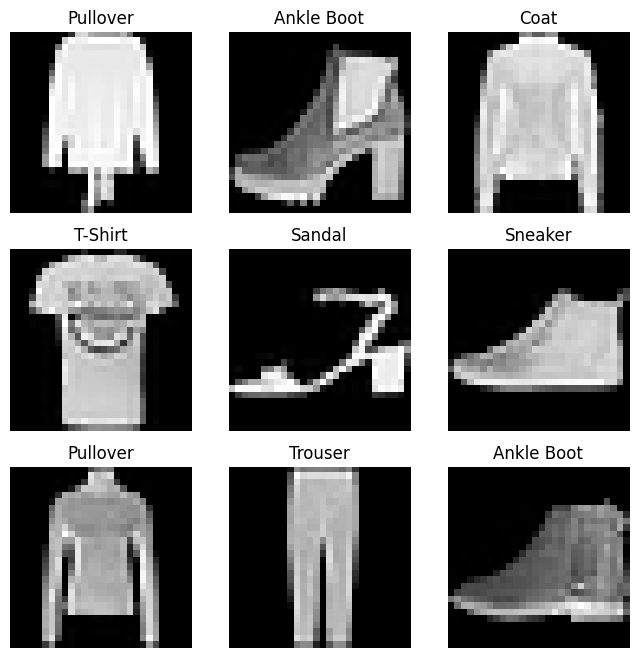

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## c. Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file `annotations_file`.

In the next sections, we’ll break down what’s happening in each of these functions.

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## d. Preparing your data for training with DataLoaders

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

**Parameters**:
- `dataset` (Dataset) – dataset from which to load the data.

- `batch_size` (int, optional) – how many samples per batch to load (default: 1).

- `shuffle` (bool, optional) – set to `True` to have the data reshuffled at every epoch (default: `False`).

- `sampler` (Sampler or Iterable, optional) – defines the strategy to draw samples from the dataset. Can be any `Iterable` with `__len__` implemented. If specified, `shuffle` must not be specified.

- `num_workers` (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: `0`)

- `collate_fn` (Callable, optional) – merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.

- `pin_memory` (bool, optional) – If `True`, the data loader will copy Tensors into device/CUDA pinned memory before returning them. If your data elements are a custom type, or your `collate_fn` returns a batch that is a custom type, see the example below.

- `drop_last` (bool, optional) – set to `True` to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If `False` and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: `False`)

- `pin_memory_device` (str, optional) – the data loader will copy Tensors into device pinned memory before returning them if pin_memory is set to true.

See [torch.utils.data documentation](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) page for more details.

## e. Iterate through the DataLoader

We have loaded that dataset into the `DataLoader` and can iterate through the dataset as needed. Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


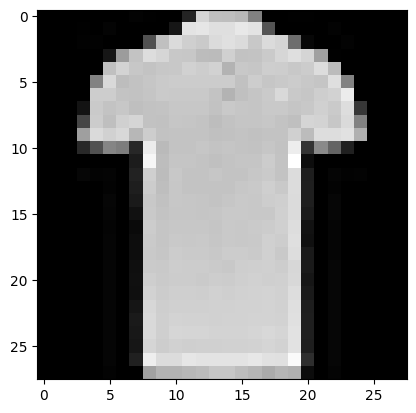

Label: 0


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## f. Transforming and augmenting images

Transforms are common image transformations. They can be chained together using `Compose`. Additionally, there is the `torchvision.transforms.functional` module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline.

All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input. Tensor Image is a tensor with `(C, H, W)` shape, where `C` is a number of channels, `H` and `W` are image height and width. Batch of Tensor Images is a tensor of `(B, C, H, W)` shape, where B is a number of images in the batch. Deterministic or random transformations applied on the batch of Tensor Images identically transform all the images of the batch.

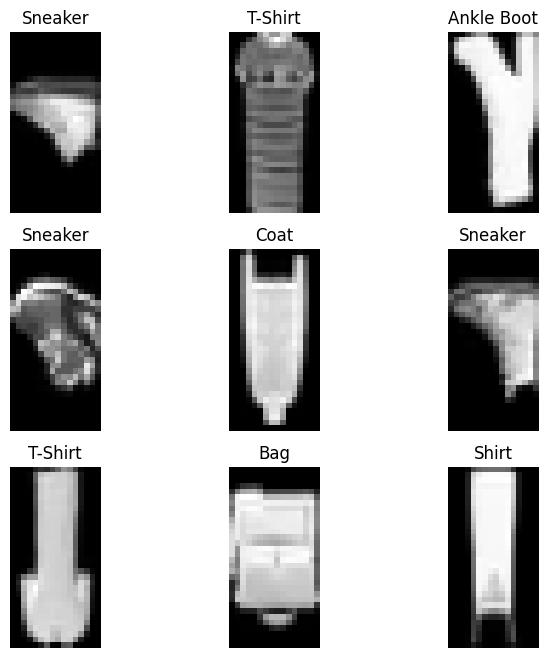

In [9]:
import torchvision.transforms as transforms


transform_train = transforms.Compose([
    transforms.Resize((32, 16)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.7),
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.Resize((32, 16)),
    transforms.ToTensor(),
    ])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_train
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

See [torchvision.transforms documentation](https://pytorch.org/vision/0.9/transforms.html) page for more details.

# 2. Build the Neural Network

Neural networks comprise of layers/modules that perform operations on data. The `torch.nn` namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the `nn.Module`. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## a. Get device for training

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## b. Define the Class

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=512, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.classifier(x)
        return x

We create an instance of `NeuralNetwork`, and move it to the `device`, and print its structure.

In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)


To use the model, we pass it the input data. This executes the model’s `forward`, along with some background operations. Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the `nn.Softmax` module.

In [15]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3])


## c. Model Layers

Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [16]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

We initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

The `linear layer` is a module that applies a linear transformation on the input using its stored weights and biases.

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In this model, we use `nn.ReLU` between our linear layers, but there’s other activations to introduce non-linearity in your model.

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.5289, -0.4380, -1.3524, -0.3841, -0.4509,  0.1481, -0.0483, -0.6283,
          0.3760, -0.0194,  0.1924, -0.5161,  0.0979, -0.0339, -0.2918,  0.0102,
         -0.0635,  0.1422,  0.2309,  0.4143],
        [-0.0839, -0.3008, -0.8349, -0.2057, -0.1021,  0.4235, -0.0747, -0.3342,
          0.2220, -0.1941,  0.3394, -0.6751,  0.0437, -0.1330, -0.4282,  0.0312,
         -0.0954, -0.1414,  0.4980,  0.1200],
        [ 0.0699, -0.3180, -0.6757,  0.0814, -0.3801,  0.1949, -0.1558, -0.3238,
          0.0494, -0.0868,  0.1775, -0.7037,  0.0771, -0.4489, -0.3283,  0.0552,
         -0.0881, -0.3569, -0.0518,  0.6217]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.5289, 0.0000, 0.0000, 0.0000, 0.0000, 0.1481, 0.0000, 0.0000, 0.3760,
         0.0000, 0.1924, 0.0000, 0.0979, 0.0000, 0.0000, 0.0102, 0.0000, 0.1422,
         0.2309, 0.4143],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4235, 0.0000, 0.0000, 0.2220,
         0.0000, 0.3394, 0.0000, 0.0437, 0.0000, 0.00

### nn.Sequential

`nn.Sequential` is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like `seq_modules`.

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
print(logits)

tensor([[-0.0776,  0.1361,  0.2071,  0.1646, -0.2131,  0.1560, -0.0587,  0.0401,
         -0.0474,  0.0158],
        [ 0.0074,  0.1641,  0.1556,  0.1002, -0.2529,  0.1705, -0.0647, -0.1100,
         -0.0321,  0.0552],
        [-0.1041,  0.0871,  0.2202,  0.2675, -0.1854,  0.0621,  0.0733, -0.0149,
         -0.0183,  0.0617]], grad_fn=<AddmmBackward0>)


### nn.Softmax

The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the `nn.Softmax` module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. `dim` parameter indicates the dimension along which the values must sum to 1.

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print(pred_probab)

tensor([[0.0889, 0.1101, 0.1182, 0.1132, 0.0776, 0.1123, 0.0906, 0.1000, 0.0916,
         0.0976],
        [0.0980, 0.1146, 0.1136, 0.1075, 0.0755, 0.1154, 0.0912, 0.0871, 0.0942,
         0.1028],
        [0.0854, 0.1034, 0.1182, 0.1239, 0.0788, 0.1009, 0.1020, 0.0934, 0.0931,
         0.1009]], grad_fn=<SoftmaxBackward0>)


## d. Model parameters

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing `nn.Module` automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)


Layer: encoder.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0025, -0.0343, -0.0109,  ..., -0.0285, -0.0317,  0.0150],
        [-0.0160,  0.0100,  0.0162,  ..., -0.0199, -0.0121, -0.0095]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: encoder.0.bias | Size: torch.Size([512]) | Values : tensor([0.0356, 0.0125], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: encoder.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0229, -0.0399,  0.0252,  ...,  0.0105,  0.0259,  0.0079],
        [-0.0395, -0.0101, -0.0209,  ..., -0.0285, -0.0052,  0.0438]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: encoder.2.b

See [torch.nn documentation](https://pytorch.org/docs/stable/nn.html) page for more details.

# Exercise


1. Create your own image processing pipeline using both `randomchoice` and `randomapply` from `torchvision.transforms`.  Try setting different probabilities for each transform function.

- There is no correct answer to this exercise.

- See [torchvision.transforms documentation](https://pytorch.org/vision/0.9/transforms.html) page for more details.

In [ ]:
import torchvision.transforms as transforms


transform = transforms.Compose([
    # Write your code here.

    transforms.ToTensor(),
    ])

2. Visit [torch.nn documentation](https://pytorch.org/docs/stable/nn.html) page to study the available activation functions and understand their unique characteristics.

3. Explore the differences between `torch.nn` and `torch.nn.functional`.